<a href="https://colab.research.google.com/github/KoMurase/movie_research_2/blob/master/research_ReadyPlayer1_TextCNN_skf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install japanize-matplotlib
!apt-get -q -y install swig 
!apt-get install mecab
!apt-get install libmecab-dev
!apt-get install mecab-ipadic-utf8
!pip install mecab-python3
!pip install unidic-lite
#日本語フォントのインストール　（wordcloudなどで可視化するため）
!apt-get -y install fonts-ipafont-gothic

!pip install neologdn 
#半角を全角に変換
!pip install mojimoji

Reading package lists...
Building dependency tree...
Reading state information...
swig is already the newest version (3.0.12-1).
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
mecab is already the newest version (0.996-5).
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libmecab-dev is already the newest version (0.996-5).
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
mecab-ipadic-utf8 is already the newest version (2.7.0-20070801+main-1).
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-ipafont-gothic is already the newest version (00303

In [2]:
!export CUDA_LAUNCH_BLOCKING=1

In [3]:
import numpy as np
from sklearn.utils import shuffle

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(1)
random_state = 42

import gc 
from tqdm import tqdm

from sklearn.model_selection import StratifiedKFold


#評価
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#混同行列
from sklearn.metrics import confusion_matrix 

import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline  

import seaborn as sns

from torch.autograd import Variable

cuda


In [47]:
MODEL_NAME = 'TextCNN'
MODELS_DIR = '/content/drive/My Drive/movie_research/models/'

In [4]:
path = "/content/drive/My Drive/movie_research/review_csv/SF_data.csv"
data = pd.read_csv(path) 

df = data[data["title"] == "レディ・プレイヤー1|Ready Player One"]
del data
gc.collect()
print('{}件のデータを扱う'.format(len(df)))

18880件のデータを扱う


In [5]:
#数値カラムに変換する
def prepro(df, col):
  df = df.copy() 
  df[col] = df[col].replace('-','-1') #回答してない人を0埋め
  df[col] = df[col].astype(float)

  return df

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


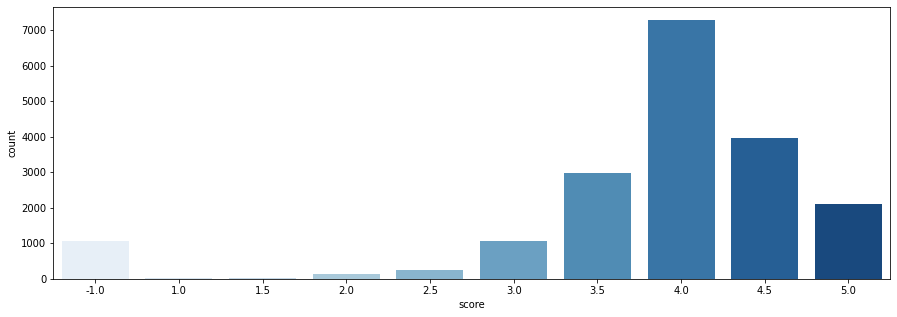

In [6]:
df = prepro(df, "score")
df["score"] = df["score"]*2.0
df["score"] = df["score"].round() / 2.0
plt.figure(figsize=(15, 5))
sns.countplot(df["score"].sort_values(), palette='Blues')

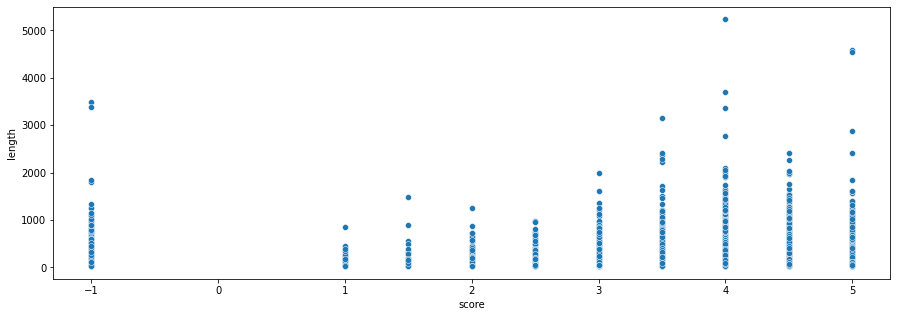

In [7]:
df["length"] = df["review"].apply(lambda x: len(x))
plt.figure(figsize=(15, 5))
sns.scatterplot(x=df["score"].sort_values(), y=df["length"], palette='YlOrBr')

In [8]:
import neologdn 
import string 
import mojimoji 
import re 

def text_preprocess(text):

  text = neologdn.normalize(text)
  #URLを除去する
  text = re.sub(
      r'(http|https)://([-\w]+\.)+[-\w]+(/[-\w./?%&=]*)?', 
      "",
      text)
  #全角から半角に
  text = mojimoji.zen_to_han(text) 

  #3D,2Dを残したい
  text = text.replace('3D','三次元')
  text = text.replace('2D','二次元')

  #数字をすべて0に置換 
  text = re.sub(r'\d+', '0', text)

  #string.punctuationの除去
  table = str.maketrans('', '', string.punctuation)
  text = text.translate(table) 

  text = text.replace("｡",'')
  text = text.replace("。",'')
  text = text.replace("，",'')
  text = text.replace(",",'')
  text = text.replace("、",'')
  text = text.replace("､",'')
  text = text.replace("…",'')
  text = text.replace("･",'')
  

  # 【】の除去
  text = re.sub(r'[【】]', '', text)
  # （）の除去
  text = re.sub(r'[（）()]', '', text)
  # ［］の除去
  text = re.sub(r'[［］\[\]]', '', text)
  #アルファベットをの大文字を小文字に変換
  text = text.lower()

  #改行コードの除去
  text = text.replace('\n', '')
  text = text.replace('\r\n','')
  
  #空白を除去
  #全角スペース
  text = text.replace('\u3000','')
  #タブキー
  text = text.replace('\t','')
  #半角
  #text = re.sub(r' ','', text) →英字幕などの指摘もあるため後で行う
  
  return text 

In [9]:
!pip install emoji 
!pip install nagisa 
#!pip install unicodedata 

import emoji
import nagisa

def delete_emoji(text):
  target_list = [w for w in text if w in emoji.UNICODE_EMOJI]
  for trg in target_list:
    text = text.replace(trg, "")
  return text 

In [10]:
df["review"] = df["review"].apply(text_preprocess) 
df["review"] = df["review"].apply(delete_emoji)

In [11]:
import MeCab
def mecab_dokuritugo(text):
  tagger = MeCab.Tagger() 
  tagger.parse('')
  node = tagger.parseToNode(text) 
  word_list = [] 
  while node: 
    pos = node.feature.split(",")[0] ### 単語の品詞を抽出
    if pos in ["動詞","形容詞"]:
      ### 動詞,形容詞の原型を抽出 
      ### [6]は原型がカタカナになって返ってくる
      word = node.feature.split(",")[7]  
      word_list.append(word) 

    elif pos in ["名詞"]: ### 名詞はそのまま
      word = node.surface 
      word_list.append(word)
    node = node.next
  return " ".join(word_list)

In [12]:
df["review_tokenize"] = df["review"].apply(mecab_dokuritugo)

In [13]:
class TextCNN(nn.Module):

  def __init__(self, vocab_size, embedding_size, class_num, kernel_num, kernel_sizes, dropout, static):
    """
     :param vocab_size: int, 入力言語の語彙数
     :param embedding_size: int, 埋め込みベクトルの次元数
     :param class_num: int, 出力のクラス数
     :param kernel_num: int,　畳み込み層の出力チャネル数
     :param kernel_sizes: list of int, カーネルのウィンドウサイズ
     :param dropout: float, ドロップアウト率
     :param static: bool, 埋め込みを固定するか否かのフラグ
    
    """
    super(TextCNN, self).__init__()
    self.static = static 
    self.embedding = nn.Embedding(vocab_size, embedding_size)
    # nn.ModuleList: 任意の数のModuleをlistのような形で保持することができるクラス
    self.convs = nn.ModuleList(
        [nn.Conv1d(1, kernel_num, (kernel_size, embedding_size)) for kernel_size in kernel_sizes]
    )
    self.dropout = nn.Dropout(dropout) 
    self.out = nn.Linear(len(kernel_sizes)*kernel_num, class_num)

  def forward(self, x):
    # x: (batch_size, max_length) 
    x = self.embedding(x) #(batch_size, max_length, embedding_size)

    if self.static:
      x = torch.tensor(x) #埋め込みを固定

    # (batch_size, 1, max_length, embedding_size)
    x = x.unsqueeze(1) 
    # [(batch_size, kernel_num, max_length-kernel_size+1), ...]*len(kernel_sizes)
    x = [F.relu(conv(x)).squeeze(3) for conv in self.convs] 
    # [(batch_size, kernel_num), ...]*len(kernel_sizes)
    x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
    # [(batch_size, len(kernel_sizes)*kernel_num)]
    x = torch.cat(x, 1)
    x = self.dropout(x) 

    logit = self.out(x) 
    return logit 

In [14]:
def sentence_to_ids(vocab, sen):
  """
  単語のリストをIDのリストに変換する関数
  :param vocab: class Vocab object
  :param sen : list of str, 文を分かち書きして得られた単語のリスト
  """
  UNK = 1

  #辞書にない言葉にUNKを割り当てる
  out = [vocab.word2id.get(word, UNK) for word in sen ]
  return out 


In [15]:
class Vocab(object):
  def __init__(self, word2id={}):
    self.word2id = dict(word2id)
    self.id2word = {v: k for k, v in self.word2id.items()}
  
  def build_vocab(self, sentences, min_count=1):
    """
    コーパスから語彙の辞書を構築するメソッド

    :param sentences: list of list of str, コーパス
    :param min_count: int, 辞書に含める単語の最小出現回数
    """
    word_counter = {}
    for sentence in sentences:
      for word in sentence:
        # dict.get(key, 0)はdictにdict[key],なければ0を返す
        word_counter[word] = word_counter.get(word, 0) + 1
    
    #min_count回以上出現する単語を加える
    for word, count in sorted(word_counter.items(), key=lambda x: -x[1]):
      if count < min_count : 
        break 
      _id = len(self.word2id)
      self.word2id.setdefault(word, _id)
      self.id2word[_id] = word 

In [16]:
def make_dataset(df):
  # 特殊なトークンは事前に定義しておく
  PAD = 0
  UNK = 1
  PAD_TOKEN = '<PAD>'
  UNK_TOKEN = '<UNK>'

  MIN_COUNT = 1  # 語彙に含める単語の最低出現回数

  # 単語をIDに変換する辞書の初期値を設定
  word2id = {
      PAD_TOKEN: PAD,
      UNK_TOKEN: UNK,
      }
  vocab = Vocab(word2id=word2id)
  vocab.build_vocab(df.values.tolist(), min_count=MIN_COUNT)

  print("語彙数:", len(vocab.word2id))
  
  return vocab

In [30]:
def train_function(dataloader, model, criterion, optimizer, scheduler, DEVICE, epoch):
  model.train() 
  total_loss = 0 
  total_corrects = 0
  all_labels = []
  all_preds = []

  #progress = tqdm(dataloader, total=len(dataloader))

  for i, batch in enumerate(dataloader):
    #progress.set_description(f"<Train> Epoch{epoch+1}")
    batch_X, batch_Y = batch 
    del batch
    batch_X, batch_Y = Variable(batch_X), Variable(batch_Y),
    optimizer.zero_grad() 

    outputs = model(batch_X).float()
    del batch_X 
    loss = criterion(outputs, batch_Y)
    loss.backward()
    optimizer.step() 
    scheduler.step() 
    preds = torch.max(outputs, 1)[1].view(batch_Y.size())
    del outputs 

    total_loss += loss.item() 
    del loss 
    total_corrects += torch.sum(preds == batch_Y)

    all_labels += batch_Y.tolist() 
    all_preds += preds.tolist() 
    del batch_Y, preds 

    #progress.set_postfix(loss=total_loss/(i+1), f1=f1_score(all_labels, all_preds, average="macro"))

    gc.collect()
  train_loss = total_loss / len(dataloader)
  #train_acc = total_corrects.double().cpu().detach().numpy() / len(dataloader.dataset)
  train_f1 = f1_score(all_labels, all_preds, average="macro")
  accuracy = accuracy_score(all_labels, all_preds)
  #tp / (tp+fn)
  #recall = recall_score(all_labels, all_preds)
  #tp / (tp+fp)
  #precision = precision_score(all_labels, all_preds)
  #F1=2*(precision*recall)/(precision + recall)
  #f1_score = f1_scorey(y_true, y_pred)
  gc.collect()
  return train_loss, accuracy, train_f1

In [38]:
def evalu_function(dataloader, model, criterion, device, epoch):
  model.eval() 
  total_loss = 0
  total_corrects = 0 
  all_labels = []
  all_preds = []

  with torch.no_grad(): 
    #progress = tqdm(dataloader, total=len(dataloader))

    for i, batch in enumerate(dataloader):
      #progress.set_description(f"Valid - Epoch{epoch+1}")
      batch_X, batch_Y = batch 
      del batch
      batch_X, batch_Y = Variable(batch_X), Variable(batch_Y),    
      
      outputs = model(batch_X).float()
      del batch_X 
      loss = criterion(outputs, batch_Y)
      preds = torch.max(outputs, 1)[1].view(batch_Y.size())
      del outputs 


      total_loss += loss.item() 
      del loss 
      total_corrects += torch.sum(preds == batch_Y)

      all_labels += batch_Y.tolist() 
      all_preds += preds.tolist() 
      del batch_Y, preds 

      #progress.set_postfix(loss=total_loss/(i+1), f1=f1_score(all_labels, all_preds, average="macro"))

      gc.collect()

    valid_loss = total_loss / len(dataloader)
    #train_acc = total_corrects.double().cpu().detach().numpy() / len(dataloader.dataset)
    #valid_f1 = f1_score(all_labels, all_preds, average="macro")
    accuracy = accuracy_score(all_labels, all_preds)
    #tp / (tp+fn)
    recall = recall_score(all_labels, all_preds, average='macro')
    #tp / (tp+fp)
    precision = precision_score(all_labels, all_preds, average='macro')
    valid_f1=2*(precision*recall)/(precision + recall)
    #f1_score = f1_scorey(y_true, y_pred)
    gc.collect()

    return valid_loss, accuracy, recall, precision, valid_f1  

In [59]:
def plot_training(train_losses, train_accs, train_f1s,
                  valid_losses, valid_accs, 
                  valid_recalls,valid_precisions,
                  valid_f1s,
                  epoch, fold):
    
    loss_df = pd.DataFrame({"Train":train_losses,
                            "Valid":valid_losses},
                        index=range(1, epoch+2))
    loss_df.to_csv(f"/content/drive/My Drive/movie_research/result/loss_plot_fold={fold}.csv", index=False)
    loss_ax = sns.lineplot(data=loss_df).get_figure()
    #/content/drive/My Drive/movie_research
    loss_ax.savefig(f"/content/drive/My Drive/movie_research/figures/loss_plot_fold={fold}.png", dpi=300)
    loss_ax.clf()

    acc_df = pd.DataFrame({"Train":train_accs,
                           "Valid":valid_accs},
                          index=range(1, epoch+2))
    acc_df.to_csv(f"/content/drive/My Drive/movie_research/result/acc_plot_fold={fold}.csv", index=False)
    acc_ax = sns.lineplot(data=acc_df).get_figure()
    acc_ax.savefig(f"/content/drive/My Drive/movie_research/figures/acc_plot_fold={fold}.png", dpi=300)
    acc_ax.clf()

    f1_df = pd.DataFrame({"Train_f1":train_f1s,
                          "Valid_f1":valid_f1s,
                          "Valid_precision":valid_precisions,
                          "Valid_recall":valid_recalls,
                            },
                         index=range(1, epoch+2))
    f1_df.to_csv(f"/content/drive/My Drive/movie_research/result/f1_plot_fold={fold}.csv", index=False)
    f1_ax = sns.lineplot(data=f1_df).get_figure()
    f1_ax.savefig(f"/content/drive/My Drive/movie_research/figures/f1_plot_fold={fold}.png", dpi=300)
    f1_ax.clf()

In [20]:
class DataLoader(object):
  def __init__(self, X, Y, batch_size, shuffle=True):
    """
    :param X: list, 入力言語の文章のリスト (単語IDのリスト)
    :param Y: list, 出力言語の文章のリスト (単語IDのリスト)
    :param batch_size: int, バッチサイズ
    :param shuffle: bool, サンプルをシャッフルするかどうか
    """
    self.data = list(zip(X, Y))
    self.batch_size = batch_size 
    self.shuffle = shuffle 
    self.start_index = 0 
    self.reset() 

  def reset(self):
    if self.shuffle:
      self.data = shuffle(self.data, random_state=random_state)
    self.start_index = 0 

  def __iter__(self):
    return self 
  def __len__(self) -> int:
    return len(self.data)
  def __next__(self):

  #ポインタが最後まで到達したら初期化する
    if self.start_index >= len(self.data): 
      self.reset() 
      raise StopIteration() 

    #バッチを取得
    X, Y = zip(*self.data[self.start_index:self.start_index+self.batch_size])
    #短い系列の末尾をパディングする
    lengths_X = [len(s) for s in X]
    max_length_X = max(lengths_X) 
    padded_X = [self.pad_seq(s, max_length_X) for s in X] 
    #tensorに変換
    batch_X = torch.tensor(padded_X, dtype=torch.long, device=device)
    batch_Y = torch.tensor(Y, dtype=torch.long, device=device)

    #ポインタを更新する
    self.start_index += self.batch_size 

    return batch_X, batch_Y 
  
  @staticmethod 
  def pad_seq(seq, max_length):
    """
    系列の末尾をパディングする 
    :param seq: list or int, 単語のインデックスのリスト
    :param seq: max_length: int, バッチ内の系列の最大長
    :return seq: list of int, 単語のインデックスのリスト
    """
    PAD = 0
    seq += [PAD for i in range(max_length - len(seq))]
    return seq 

In [40]:
def trainer(fold, df, batch_size, lr, EPOCHS, weight):

  train_df = df[df.kfold != fold].reset_index(drop=True)
  valid_df = df[df.kfold == fold].reset_index(drop=True)

  train_X = train_df["tokenize"]
  train_y = train_df["score"]
  valid_X = valid_df["tokenize"]
  valid_y = valid_df["score"] 

  #訓練データを使って辞書を作る
  vocab = make_dataset(train_X)

  ###データセットの作成
  #各データをid化
  train_X = [sentence_to_ids(vocab, x) for x in train_X]
  valid_X = [sentence_to_ids(vocab, x) for x in valid_X]

  train_dataloader = DataLoader(train_X, train_y, batch_size)
  valid_dataloader = DataLoader(valid_X, valid_y, batch_size)

  model_args = {
      'vocab_size': len(vocab.id2word),
      'embedding_size': 128,
      'class_num': 9,
      'kernel_num': 64, 
      'kernel_sizes': [3,4,5],
      'dropout': 0.5, 
      'static': False,
  }
  #modelの設定 
  model = TextCNN(**model_args)
  model = model.to(device)

  #if weight != None:
  #  criterion = nn.CrossEntropyLoss(weight=weights.to(device))
  #else:
  #  criterion = nn.CrossEntropyLoss()
  criterion = nn.CrossEntropyLoss()
  
  #AdamWを使ってみる
  optimizer = optim.AdamW(model.parameters(), lr=lr)

  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=1.0)

  train_losses = []
  train_accs = []
  train_f1s = []
  valid_losses = []
  valid_accs = []
  valid_f1s = []
  valid_recalls = []
  valid_precisions = []
 
  best_loss = np.inf 
  best_acc = 0 
  best_f1 = 0 

  for epoch in range(EPOCHS):
    train_loss, train_acc, train_f1 = train_function(train_dataloader, model, criterion, optimizer, scheduler, device, epoch)
    valid_loss, valid_acc, valid_recall, valid_precision, valid_f1 = evalu_function(valid_dataloader, model, criterion, device, epoch)
    print(f"Loss: {valid_loss}  Acc: {valid_acc}  f1: {valid_f1}  ")

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    train_f1s.append(train_f1)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    valid_recalls.append(valid_recall)
    valid_precisions.append(valid_precision)
    valid_f1s.append(valid_f1)

    plot_training(train_losses, train_accs, train_f1s,
                      valid_losses, valid_accs, 
                      valid_recalls,valid_precisions,
                      valid_f1s,
                      epoch, fold)

    best_loss = valid_loss if valid_loss < best_loss else best_loss
    besl_acc = valid_acc if valid_acc > best_acc else best_acc
    if valid_f1 > best_f1:
      best_f1 = valid_f1
      print("model saving!", end="")
      torch.save(model.state_dict(), MODELS_DIR + f"best_{MODEL_NAME}_{fold}.pth")
      print("\n")

    return best_f1


In [22]:
from sklearn.preprocessing import LabelEncoder


def create_folds(df, num_splits):
    df = df.copy()
    #df["jobflag"] = df["jobflag"] - 1
    df["kfold"] = -1 

    #fracで抽出する行の割合1は100%
    df = df.sample(frac=1).reset_index(drop=True)
    y = df["score"].values 
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    
    skf = StratifiedKFold(n_splits=num_splits)

    for f, (t_, v_) in enumerate(skf.split(X=df, y=y)):
        df.loc[v_,'kfold'] = f ###locより高速
    return df

In [23]:
df.info() 


<class 'pandas.core.frame.DataFrame'>
Int64Index: 18880 entries, 412299 to 431178
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            18880 non-null  object 
 1   name             18880 non-null  object 
 2   time             18880 non-null  object 
 3   review           18880 non-null  object 
 4   score            18880 non-null  float64
 5   URL              18880 non-null  object 
 6   length           18880 non-null  int64  
 7   review_tokenize  18880 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 1.9+ MB


In [24]:
NUM_SPLITS = 5

test_df = df[df.score == -1]
df = df[df.score != -1]

df = create_folds(df, NUM_SPLITS)

In [25]:
test_df.head() 

,title,name,time,review,score,URL,length,review_tokenize
412313,レディ・プレイヤー1|Ready Player One,べすの感想・評価,2020/08/16 15:46,映画ｹﾞｰﾑ昔の音楽知っていると楽しいところがいくつかあって遊び心がかいまみれた俺はｶﾞﾝﾀ...,-1.0,https://filmarks.com//movies/63747?page=10,60,映画 ｹﾞｰﾑ 昔 音楽 知る 居る 楽しい ところ いく 有る 遊び心 垣間見る ｶﾞﾝﾀ...
412326,レディ・プレイヤー1|Ready Player One,TaikiSoneの感想・評価,2020/07/06 23:55,ｵﾓﾛかったｰﾘｱﾙとｵｱｼｽ仮想世界ｼｬｲﾆﾝｸﾞのｼｰﾝは笑うこの手のﾀｲﾌﾟも意外によ...,-1.0,https://filmarks.com//movies/63747?page=100,59,ｵﾓﾛ 買う ｰﾘｱﾙ ｵｱｼｽ 仮想 世界 ｼｬｲﾆﾝｸﾞ ｼｰﾝ 笑う 手 ﾀｲﾌﾟ か...
412372,レディ・プレイヤー1|Ready Player One,N村の感想・評価,2018/09/09 07:08,是非usjのﾊﾞｯｸﾄｩｰｻﾞﾌｭｰﾁｬｰのｱﾄﾗｸｼｮﾝやったところでやってほしい,-1.0,https://filmarks.com//movies/63747?page=1004,42,usj ﾊﾞｯｸﾄｩｰｻﾞﾌｭｰﾁｬｰ ｱﾄﾗｸｼｮﾝ 遣る ところ 遣る 欲しい
412381,レディ・プレイヤー1|Ready Player One,おかだの感想・評価,2018/09/09 01:34,面白いのはもちろんなんだが最近盛り上がってきたばかりの気がするvrを早くも題材にして作り上げ...,-1.0,https://filmarks.com//movies/63747?page=1005,152,面白い 最近 盛り上がる 来る 気 為る vr 早い 題材 為る 作り上げる ところ ｽﾋﾟ...
412430,レディ・プレイヤー1|Ready Player One,RIKEの感想・評価,2020/07/06 23:26,所々にﾎﾟｯﾌﾟｶﾙﾁｬｰ感じられる小ﾈﾀが散りばめられていて宝探しのようだったｺﾞｰﾙﾃﾞ...,-1.0,https://filmarks.com//movies/63747?page=101,63,所々 ﾎﾟｯﾌﾟｶﾙﾁｬｰ 感ずる ﾈﾀ 鏤める 居る 宝探し ｺﾞｰﾙﾃﾞｨｳｨﾙｿﾝ ﾎ...


In [26]:
df.head()

,title,name,time,review,score,URL,length,review_tokenize,kfold
0,レディ・プレイヤー1|Ready Player One,かふぃの感想・評価,2018/05/17 11:03,0dで鑑賞したらあんまり集中できなかったけど面白かった数十年後には仮想世界で生きていくように...,4.0,https://filmarks.com//movies/63747?page=1366,55,0 d 鑑賞 為る 集中 出来る 面白い 数十 年 仮想 世界 生きる 行く 成る,0
1,レディ・プレイヤー1|Ready Player One,らの感想・評価,2018/06/11 23:01,記録vrの世界すごいｱﾄﾗｸｼｮﾝ感ある主人公の呼びかけに皆が応じるのとありがとう僕のｹﾞｰ...,4.5,https://filmarks.com//movies/63747?page=1176,67,記録 vr 世界 凄い ｱﾄﾗｸｼｮﾝ 感 有る 主人 呼びかけ 皆 応ずる ｹﾞｰﾑ ﾌﾟ...,0
2,レディ・プレイヤー1|Ready Player One,もふもふさんの感想・評価,2018/05/09 19:06,すごいよかったｽﾄｰﾘｰが面白い今は非現実だけどもしかしたらこんな時代が来るかもしれないって...,4.5,https://filmarks.com//movies/63747?page=1497,88,凄い 良い ｽﾄｰﾘｰ 面白い 今 現実 為る 時代 来る 知れる 考える 不安 期待 両方...,0
3,レディ・プレイヤー1|Ready Player One,Mamiの感想・評価,2020/04/27 16:59,ｽﾋﾟﾙﾊﾞｰｸﾞ監督はやっぱりすごいおもしろかったﾊﾞｰﾁｬﾙとﾘｱﾙの世界,4.5,https://filmarks.com//movies/63747?page=283,38,ｽﾋﾟﾙﾊﾞｰｸﾞ 監督 凄い 面白い ﾊﾞｰﾁｬﾙ ﾘｱﾙ 世界,0
4,レディ・プレイヤー1|Ready Player One,わたしの感想・評価,2019/01/28 15:41,なんせﾃﾝﾎﾟがいいb級ぽいと思いきや全然ちがう楽しくてﾜｸﾜｸして仕方ない作品でしたそれと...,4.5,https://filmarks.com//movies/63747?page=738,65,ﾃﾝﾎﾟ 良い b 思う 違う 楽しい ﾜｸﾜｸ 為る 仕方無い 作品 ｼｬｲﾆﾝｸﾞ 知る 怖い,0


In [27]:
df = df[["review_tokenize", "score","kfold"]]
df = df.rename(columns={"review_tokenize":"tokenize"})
df

,tokenize,score,kfold
0,0 d 鑑賞 為る 集中 出来る 面白い 数十 年 仮想 世界 生きる 行く 成る,4.0,0
1,記録 vr 世界 凄い ｱﾄﾗｸｼｮﾝ 感 有る 主人 呼びかけ 皆 応ずる ｹﾞｰﾑ ﾌﾟ...,4.5,0
2,凄い 良い ｽﾄｰﾘｰ 面白い 今 現実 為る 時代 来る 知れる 考える 不安 期待 両方...,4.5,0
3,ｽﾋﾟﾙﾊﾞｰｸﾞ 監督 凄い 面白い ﾊﾞｰﾁｬﾙ ﾘｱﾙ 世界,4.5,0
4,ﾃﾝﾎﾟ 良い b 思う 違う 楽しい ﾜｸﾜｸ 為る 仕方無い 作品 ｼｬｲﾆﾝｸﾞ 知る 怖い,4.5,0
...,...,...,...
17821,日本 有る こと 誇り 感ずる ｱﾊﾞﾀｰ 為る,4.0,4
17822,現実 世界 ﾊﾞｰﾁｬﾙﾘｱﾘﾃｨ 世界 没頭 為る 居る 人々 溢れる 未来 描く 映画 ...,4.0,4
17823,ｹﾞｰﾑ 遣る 見る 違う 自分 慣れる 仕舞う 言う 莫大 財産 手 入る 言う ｹﾞｰﾑ...,3.5,4
17824,ｵﾀｸ 楽しむ 場面 満載 友情 愛 詰まる 映画 現実 世界 ﾊﾞｰﾁｬﾙ 世界 関係 ﾊ...,4.0,4


In [28]:
df.score.value_counts() 


4.0    7285
4.5    3975
3.5    2975
5.0    2104
3.0    1050
2.5     237
2.0     132
1.0      35
1.5      33
Name: score, dtype: int64

In [60]:
f1_scores = []
BATCH_SIZE = 128
lr = 0.001 
NUM_EPOCHS = 500

for fold in range(NUM_SPLITS):
    print(f"fold {fold}", "="*70)
    f1 = trainer(fold, df,BATCH_SIZE,lr, NUM_EPOCHS,weight=None)
    f1_scores.append(f1)
    print(f"<fold={fold}> best score: {f1}\n")

fold 0 ======================================================================
語彙数: 2485


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Loss: 0.0076140520516500935  Acc: 0.6315199102636007  f1: 0.15482983843245104  
model saving!

<fold=0> best score: 0.15482983843245104

fold 1 ======================================================================
語彙数: 2465


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Loss: 0.0074500950322412005  Acc: 0.6319775596072932  f1: 0.24839227461794303  
model saving!

<fold=1> best score: 0.24839227461794303

fold 2 ======================================================================
語彙数: 2493


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Loss: 0.007438329560225007  Acc: 0.6311360448807855  f1: 0.18740302210786391  
model saving!

<fold=2> best score: 0.18740302210786391

fold 3 ======================================================================
語彙数: 2454


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Loss: 0.007426655409546754  Acc: 0.6319775596072932  f1: 0.21252729011200092  
model saving!

<fold=3> best score: 0.21252729011200092

fold 4 ======================================================================
語彙数: 2480


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Loss: 0.007503424938062799  Acc: 0.6319775596072932  f1: 0.24820799993222553  
model saving!

<fold=4> best score: 0.24820799993222553



<Figure size 432x288 with 0 Axes>

In [49]:
cv = sum(f1_scores) / len(f1_scores)
print(f"CV: {cv}")

CV: 0.16638529883937003
